# Generate features from text and use Multinomial Naive Bayes to predict fake news

Reference
* https://github.com/justmarkham/pycon-2016-tutorial/blob/master/tutorial_with_output.ipynb
* https://www.youtube.com/watch?v=hXNbFNCgPfY

## Generate data

In [384]:
import pandas as pd
import numpy as np
import os
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.preprocessing import binarize

### read data from files

In [385]:
path = os.path.join('data', 'balanced_data.csv')
data_balanced = pd.read_csv(path, usecols=[1,2,3,4,5,7])
data_balanced.tail()

,url,source,title,author,text,label_num
1994,http://www.bighairynews.com/2017/07/military-t...,Bighairynews,Military Trannies Trumped,[],WASHINGTON (World News Bureau) - President Tru...,1
1995,http://bipartisanreport.com/2017/07/27/scaramu...,bipartisanreport,Scaramucci Responds To Article About His Profa...,['Holly Lee'],Anthony Scaramucci is facing serious scorn aft...,1
1996,https://amgreatness.com/2017/07/19/muellers-in...,wordpress,Mueller’s Investigation Must Be Limited and Ac...,"['Andrew C. Mccarthy', 'Sam Mcgowan', 'Bill S'...",How much goalpost moving should be tolerable i...,1
1997,http://www.politico.com/story/2017/07/26/scara...,wordpress,Scaramucci still stands to profit from SkyBrid...,"['Lorraine Woellert', 'Cristiano Lima', 'Tara ...",The incoming White House communications direct...,1
1998,http://beforeitsnews.com/health/2017/07/how-po...,beforeitsnews,How potatoes can increase the risk of cancer c...,['Natural Health'],(Before It's News)\n\n(NaturalHealth365) A rec...,1


In [ ]:
# drop a column
#news_data.drop(['authenticity'], axis = 1, inplace = True)
#news_data.head()

In [386]:
data_balanced.label_num.value_counts()

0    1002
1     997
Name: label_num, dtype: int64

## Convert text to numbers (features)

### Define x and y for modeling later, and split data into training and testing sets

In [387]:
from sklearn.cross_validation import train_test_split

In [388]:
x = data_balanced.text
y = data_balanced.label_num
print(x.shape)
print(y.shape)

(1999,)
(1999,)


In [389]:
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1499,)
(500,)
(1499,)
(500,)


In [390]:
y_train.value_counts()

1    752
0    747
Name: label_num, dtype: int64

### customized tokenize function for stemming and removing punctuation
codes are taken from https://stackoverflow.com/questions/26126442/combining-text-stemming-and-removal-of-punctuation-in-nltk-and-scikit-learn

In [391]:
import nltk
import string
from nltk.stem.porter import PorterStemmer

stemmer = PorterStemmer()
def stem_tokens(tokens, stemmer):
    stemmed = []
    for item in tokens:
        stemmed.append(stemmer.stem(item))
    return stemmed

def tokenize_stemmer(text):
    tokens = nltk.word_tokenize(text)
    #tokens = [i for i in tokens if i not in string.punctuation]
    stems = stem_tokens(tokens, stemmer)
    return stems

### Method 1: Use CountVectorizer to generate features

In [12]:
# import and instantiate CountVectorizer (with the default parameters)
from sklearn.feature_extraction.text import CountVectorizer

In [25]:
# instantiate the vectorizer
vect = CountVectorizer(tokenizer=tokenize_stemmer,stop_words='english',ngram_range=(2, 2))

In [98]:
# learn training data vocabulary, then use it to create a document-term matrix
vect.fit(x_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(2, 2), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize_stemmer at 0x30b9ded08>,
        vocabulary=None)

In [100]:
x_train_dtm = vect.transform(x_train)
# examine the document-term matrix
x_train_dtm

<1499x422215 sparse matrix of type '<class 'numpy.int64'>'
	with 551598 stored elements in Compressed Sparse Row format>

In [17]:
x_train_dtm.toarray()[0]

array([0, 0, 0, ..., 0, 0, 0])

In [101]:
# transform testing data (using fitted vocabulary) into a document-term matrix
x_test_dtm = vect.transform(x_test)
x_test_dtm

<500x422215 sparse matrix of type '<class 'numpy.int64'>'
	with 62009 stored elements in Compressed Sparse Row format>

### Method 2: use TF-IDF to generate features

In [392]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(tokenizer=tokenize_stemmer,stop_words='english',
                        ngram_range=(2, 2))
tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(2, 2), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words='english', strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function tokenize_stemmer at 0x11f5f32f0>, use_idf=True,
        vocabulary=None)

In [393]:
x_train_dtm = tfidf.fit_transform(x_train)

# examine the document-term matrix
x_train_dtm

<1499x395876 sparse matrix of type '<class 'numpy.float64'>'
	with 639804 stored elements in Compressed Sparse Row format>

In [394]:
x_test_dtm = tfidf.transform(x_test)
x_test_dtm

<500x395876 sparse matrix of type '<class 'numpy.float64'>'
	with 103403 stored elements in Compressed Sparse Row format>

## Selecting features
http://scikit-learn.org/stable/modules/feature_selection.html#univariate-feature-selection

chi-square test measures dependence between stochastic variables

Using this function “weeds out” the features that are the most likely to be independent of class and therefore irrelevant for classification.

In [181]:
from sklearn.feature_selection import SelectPercentile, SelectKBest, f_classif, chi2

In [395]:
# select top 8% features
#selector = SelectPercentile(chi2, percentile = 8) 

# select top 25000 features
selector = SelectKBest(chi2, k = 25000) 

selector.fit(x_train_dtm, y_train)

SelectKBest(k=25000, score_func=<function chi2 at 0x119b41598>)

In [396]:
x_train_selected = selector.transform(x_train_dtm)
x_train_selected

<1499x25000 sparse matrix of type '<class 'numpy.float64'>'
	with 110461 stored elements in Compressed Sparse Row format>

In [397]:
x_test_selected = selector.transform(x_test_dtm)
x_test_selected

<500x25000 sparse matrix of type '<class 'numpy.float64'>'
	with 28387 stored elements in Compressed Sparse Row format>

### plot the tf-idf values of top features in each document

In [476]:
# select top features
sel = SelectKBest(chi2, k = 500)
sel.fit(x_train_dtm, y_train)

SelectKBest(k=500, score_func=<function chi2 at 0x119b41598>)

In [477]:
x_train_sel = sel.transform(x_train_dtm)
x_train_sel
#x_test_sel = sel.transform(x_test_dtm)
#x_test_sel

<1499x500 sparse matrix of type '<class 'numpy.float64'>'
	with 17798 stored elements in Compressed Sparse Row format>

In [478]:
# get the fake news documents
ids = np.where(y_test==1)
fake_feats = x_train_sel[ids].toarray()[0:200,:]
fake_feats.shape

(200, 500)

In [479]:
# get the real news documents
ids = np.where(y_test==0)
real_feats = x_train_sel[ids].toarray()[0:200,:]
real_feats.shape

(200, 500)

In [480]:
feats = np.concatenate([fake_feats, real_feats])
#feats = real_feats
feats = np.transpose(feats, (1, 0))
feats.shape

(500, 400)

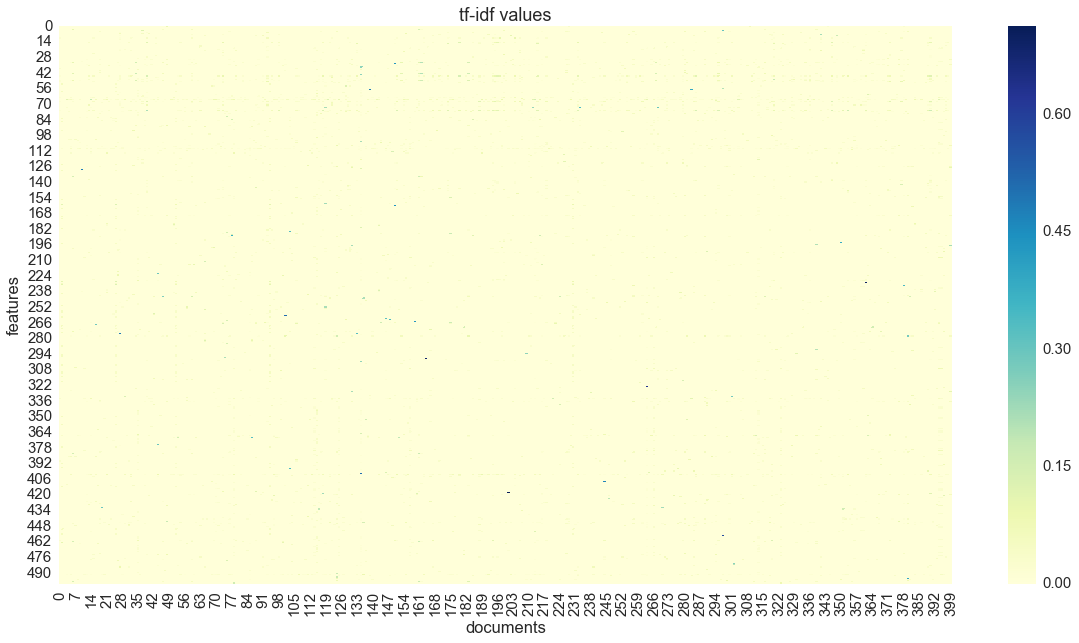

In [481]:
# plot the heatmap
import seaborn as sns; 
sns.set(font_scale=1.5)
plt.subplots(figsize=(20,10))
ax = sns.heatmap(feats,cmap="YlGnBu")
ax.set_ylabel('features')  
ax.set_xlabel('documents')  
ax.set_title('tf-idf values')

## Predicting fake news using Multinomial Naive Bayes 

In [16]:
from sklearn.naive_bayes import MultinomialNB

In [124]:
nb = MultinomialNB()

# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb.fit(x_train_dtm, y_train)

CPU times: user 22.6 ms, sys: 11.5 ms, total: 34.2 ms
Wall time: 32.9 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [71]:
# make class predictions for x_test_dtm
y_pred_class = nb.predict(x_test_dtm)

# calculate accuracy of class predictions
metrics.accuracy_score(y_test, y_pred_class) # or nb.score(x_test_dtm,y_test)

0.92600000000000005

In [60]:
# calculate F1 score
f1_score(y_test,y_pred_class)

0.92525252525252533

In [36]:
# print the confusion matrix
metrics.confusion_matrix(y_test, y_pred_class)

array([[234,  21],
       [ 16, 229]])

In [ ]:
# print the false positives (real news incorrectly classified as fake)
x_test[y_test < y_pred_class]

In [ ]:
# example false positives
#x_test[1747]

In [ ]:
# print the false negatives (fake news incorrectly classified as real)
x_test[y_test > y_pred_class]

In [ ]:
# example false negative
# x_test[2096]

### using selected features

In [474]:
nb2 = MultinomialNB()

# train the model using X_train_dtm (timing it with an IPython "magic command")
%time nb2.fit(x_train_selected, y_train)

CPU times: user 3.27 ms, sys: 1.86 ms, total: 5.13 ms
Wall time: 3.94 ms


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [475]:
# make class predictions for x_test_dtm
y_pred_selected = nb2.predict(x_test_selected)

print("accuracy: ", metrics.accuracy_score(y_test, y_pred_selected))
print("F1 score: ", f1_score(y_test,y_pred_selected))

accuracy:  0.932
F1 score:  0.929752066116


### adjusting the classification threshold

In [282]:
# store the predicted probabilities for class 1
y_pred_prob = nb2.predict_proba(x_test_selected)[:, 1]

# predict diabetes if the predicted probability is greater than 0.54
y_pred_new = binarize([y_pred_prob], 0.51)[0]

print("accuracy: ", metrics.accuracy_score(y_test, y_pred_new))
print("F1 score: ", f1_score(y_test,y_pred_new))

accuracy:  0.924
F1 score:  0.919831223629


## Predicting fake news using logistic regression

In [31]:
# import and instantiate a logistic regression model
from sklearn.linear_model import LogisticRegression

In [278]:
logreg = LogisticRegression()

# train the model using X_train_dtm
%time logreg.fit(x_train_dtm, y_train)

CPU times: user 165 ms, sys: 9.19 ms, total: 174 ms
Wall time: 173 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [279]:
# make class predictions for X_test_dtm
y_pred_class = logreg.predict(x_test_dtm)

# calculate accuracy 
metrics.accuracy_score(y_test, y_pred_class)

print("accuracy: ", metrics.accuracy_score(y_test, y_pred_class))
print("F1 score: ", f1_score(y_test,y_pred_class))

accuracy:  0.874
F1 score:  0.879541108987


### using selected features

In [207]:
logreg2 = LogisticRegression()

# train the model using X_train_dtm
%time logreg2.fit(x_train_selected, y_train)

CPU times: user 12.8 ms, sys: 2.38 ms, total: 15.1 ms
Wall time: 13.8 ms


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [277]:
# make class predictions for x_test_dtm
y_pred_selected = logreg2.predict(x_test_selected)

# calculate accuracy of class predictions
metrics.accuracy_score(y_test, y_pred_selected) 

print("accuracy: ", metrics.accuracy_score(y_test, y_pred_selected))
print("F1 score: ", f1_score(y_test,y_pred_selected))

accuracy:  0.872
F1 score:  0.87786259542


### adjusting the classification threshold
https://github.com/justmarkham/scikit-learn-videos/blob/master/09_classification_metrics.ipynb

In [226]:
# print the first 25 true and predicted responses
print('True:', y_test.values[0:35])
print('Pred:', y_pred_selected[0:35])

True: [0 1 0 0 1 0 0 0 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 0 0 0 1 1 0 0 0]
Pred: [0 1 0 1 1 0 0 0 1 0 1 1 1 1 0 1 1 1 1 0 0 1 0 1 1 0 0 1 0 0 1 1 0 0 1]


In [229]:
# store the predicted probabilities for class 1
y_pred_prob = logreg2.predict_proba(x_test_selected)[:, 1]

In [227]:
plt.rcParams['font.size'] = 14

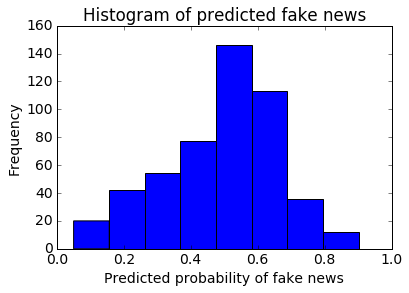

In [231]:
# histogram of predicted probabilities
plt.hist(y_pred_prob, bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted fake news')
plt.xlabel('Predicted probability of fake news')
plt.ylabel('Frequency')

In [267]:
# predict diabetes if the predicted probability is greater than 0.54
y_pred_new = binarize([y_pred_prob], 0.54)[0]

print("accuracy: ", metrics.accuracy_score(y_test, y_pred_new))
print("F1 score: ", f1_score(y_test,y_pred_new))

accuracy:  0.884
F1 score:  0.878661087866


In [233]:
# new confusion matrix (threshold of 0.3)
print(metrics.confusion_matrix(y_test, y_pred_new))

[[133 122]
 [  6 239]]
